# PML VAE's

In [11]:
import torchvision.datasets as datasets
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt


import pyro
from pyro.contrib.examples.util import MNIST
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
cuda2 = False
batch_size2 = 128
log_interval2 = 10
epochs2 = 4 # 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)


mnist_trainset = datasets.MNIST('../data', train=True, download=True,transform=transforms.ToTensor())
mnist_testset = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

## Baseline VAE:

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # Latent space of 2D
        self.fc22 = nn.Linear(100, 2) # Latent space of 2D
        self.fc3 = nn.Linear(2, 100) # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Convolutional VAE:

In [6]:
class VAET(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        self.lin_dec = nn.Linear(encoded_space_dim, 6*6*32)

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=(2, 2)),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=(2, 2)),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(64*6*6, out_features=encoded_space_dim*2)
        )

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=1)
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decoder(self, x):
        x = self.lin_dec(x)
        x = F.relu(x)
        x = torch.reshape(x,(-1,32,6,6))
        return self.decoder_cnn(x)

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = x.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return torch.sigmoid(out), mu, logvar

## Training and testing functions:

In [34]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, conv = False):
    if conv:
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch, model, optimizer, conv = False):
    model.train() 
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, conv)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    return train_loss / len(train_loader.dataset)


def test(epoch, model, conv = False):
    model.eval()
    test_loss = 0
    with torch.no_grad(): 
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar, conv).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
    return test_loss

## Training loops: (SKIP THIS IF YOU WANT TO LOAD PRETRAINED MODELS)

Train baseline VAE with linear layers:

In [35]:
# Define model
model = VAE().to(device)
optimizer_model = optim.Adam(model.parameters(), lr=1e-3)
epochs2 = 10

train_vec_model = []
test_vec_model = []

# Train baseline VAE
for epoch in range(1, epochs2 + 1):
    loss_train = train(epoch, model, optimizer_model)
    train_vec_model.append(loss_train)
    loss_test = test(epoch, model)
    test_vec_model.append(loss_test)

====> Epoch: 1 Average loss: 187.7989
====> Test set loss: 167.8263
====> Epoch: 2 Average loss: 163.6223
====> Test set loss: 160.2029
====> Epoch: 3 Average loss: 157.4014
====> Test set loss: 155.1194
====> Epoch: 4 Average loss: 153.5937
====> Test set loss: 152.3608
====> Epoch: 5 Average loss: 151.0607
====> Test set loss: 150.4765
====> Epoch: 6 Average loss: 149.2414
====> Test set loss: 148.7436
====> Epoch: 7 Average loss: 147.7286
====> Test set loss: 147.5361
====> Epoch: 8 Average loss: 146.4459
====> Test set loss: 146.5493
====> Epoch: 9 Average loss: 145.6915
====> Test set loss: 146.0246
====> Epoch: 10 Average loss: 144.8630
====> Test set loss: 145.3673


Save the modelfile to avoid retraining:

In [68]:
torch.save(model, "vae_linear")
torch.save(train_vec_model, "train_vec_model")
torch.save(test_vec_model, "test_vec_model")

Train convolution VAE:

In [55]:
# Define model
model_conv = VAET(encoded_space_dim=2).to(device)
optimizer_model_conv = optim.Adam(model_conv.parameters(), lr=1e-3)
epochs2 = 10

train_vec_model_conv = []
test_vec_model_conv = []

# Train convolutional VAE
for epoch in range(1, epochs2 + 1):
    train_loss = train(epoch, model_conv, optimizer_model_conv, conv = True)
    train_vec_model_conv.append(train_loss)
    test_loss = test(epoch, model_conv, conv = True)
    test_vec_model_conv.append(test_loss)

====> Epoch: 1 Average loss: 202.7454
====> Test set loss: 173.0460
====> Epoch: 2 Average loss: 168.7619
====> Test set loss: 165.1864
====> Epoch: 3 Average loss: 163.2114
====> Test set loss: 161.3845
====> Epoch: 4 Average loss: 160.6794
====> Test set loss: 159.2864
====> Epoch: 5 Average loss: 159.1342
====> Test set loss: 157.9758
====> Epoch: 6 Average loss: 158.0787
====> Test set loss: 158.2725
====> Epoch: 7 Average loss: 157.3306
====> Test set loss: 157.0606
====> Epoch: 8 Average loss: 156.5866
====> Test set loss: 156.0375
====> Epoch: 9 Average loss: 156.0954
====> Test set loss: 155.8659
====> Epoch: 10 Average loss: 155.6791
====> Test set loss: 155.0439


Save the torch modelfile to avoid retraining:

In [66]:
torch.save(model_conv, "vae_conv")
torch.save(train_vec_model_conv, "train_vec_model_conv")
torch.save(test_vec_model_conv, "test_vec_model_conv")

## PPCA:

In [7]:
N = len(mnist_trainset)
data_vec = torch.reshape(mnist_trainset.data, (60000, 28*28)) # Make into vector (28x28 = 784)
data_cov = torch.cov(data_vec.T)  # covariance of data (dim=784x784)
data_eig = torch.linalg.eig(data_cov)  # tensor of the eigenvectores of data_cov
D = data_eig.eigenvectors.shape[1]  # length of eigenvectors (= 784)
M = 2
sig_sq = 1/(D-M)*torch.sum(data_eig.eigenvalues[2:])  # sigma^2 (real number), see equation 12.46
U_M = data_eig.eigenvectors[:,:2]  # columns are the first two (= M) eigenvectors of data covariance (dim=782x2)
L_M = torch.diag(data_eig.eigenvalues[:2])  # diagonal matrix with two corresponding eigenvalues on det diagonal (dim=2x2)
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(2))**0.5)  # W from formula above (dim=784x2)
data_vec_double = data_vec.type(torch.DoubleTensor)  # changes the data type of the tensor data_vec(=x) to double precision floating point (dim=60000x784)
mu = torch.mean(data_vec_double, 0)  # takes column mean (one mean value for each pixel) (dim = 784)
M = torch.matmul(W.T, W) + sig_sq * torch.eye(2)  # calculates M from formula above (matmul er matrix multiplication) (dim = 2x2)

In [8]:
N = len(mnist_testset)
data_vec_test = torch.reshape(mnist_testset.data, (10000, 28*28)) # Make into vector (28x28 = 784)
data_vec_double_test = data_vec_test.type(torch.DoubleTensor)  # changes the data type of the tensor data_vec(=x) to double precision floating point (dim=60000x784)
x_mu = data_vec_double_test.T - mu.repeat(N,1).T  # calculates (x - mu) from equation above (dim = 784x60000) 

temp = torch.inverse(M)@W.T
# x_mu_complex = x_mu.type(torch.complex64)
temp_double = temp.type(torch.double)  # double precision (uses more memory)
z_values = temp_double@x_mu  # z (latent variable): for every data point (n=60000) the 2 dimensional vector representing data (dim = 2x60000)
# calculated as the mean from p(z|x) above e.i. E[z|x]
W_double = W.type(torch.double)
WWinv = torch.inverse(W_double.T@W_double)
M_double = M.type(torch.double)
xstar = W_double@WWinv@W_double.T@x_mu  # reconstruction of the images (dim = 784, 60000)

/tmp/ipykernel_75277/3223656452.py:8: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  temp_double = temp.type(torch.double)  # double precision (uses more memory)


In [9]:
N = len(mnist_trainset)
data_vec = torch.reshape(mnist_trainset.data, (60000, 28*28)) # Make into vector (28x28 = 784)
data_cov = torch.cov(data_vec.T)  # covariance of data (dim=784x784)
data_eig = torch.linalg.eig(data_cov)  # tensor of the eigenvectores of data_cov
D = data_eig.eigenvectors.shape[1]  # length of eigenvectors (= 784)
M = 80
sig_sq = 1/(D-M)*torch.sum(data_eig.eigenvalues[M:])  # sigma^2 (real number), see equation 12.46
U_M = data_eig.eigenvectors[:,:M]  # columns are the first M eigenvectors of data covariance (dim=782x80)
L_M = torch.diag(data_eig.eigenvalues[:M])  # diagonal matrix with M corresponding eigenvalues on det diagonal (dim=80x80)
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(M))**0.5)  # W from formula above (dim=784x80)
data_vec_double = data_vec.type(torch.DoubleTensor)  # changes the data type of the tensor data_vec(=x) to double precision floating point (dim=60000x784)
mu = torch.mean(data_vec_double, 0)  # takes column mean (one mean value for each pixel) (dim = 784)
M = torch.matmul(W.T, W) + sig_sq * torch.eye(M)  # calculates M from formula above (matmul er matrix multiplication) (dim = 80x80)
N = len(mnist_testset)
data_vec_test = torch.reshape(mnist_testset.data, (10000, 28*28)) # Make into vector (28x28 = 784)
data_vec_double_test = data_vec_test.type(torch.DoubleTensor)  # changes the data type of the tensor data_vec(=x) to double precision floating point (dim=60000x784)
x_mu = data_vec_double_test.T - mu.repeat(N,1).T  # calculates (x - mu) from equation above (dim = 784x10000) 

temp = torch.inverse(M)@W.T
# x_mu_complex = x_mu.type(torch.complex64)
temp_double = temp.type(torch.double)  # double precision (uses more memory)
z_values = temp_double@x_mu  # z (latent variable): for every data point (n=10000) the 80 dimensional vector representing data (dim = 80x10000)
print(z_values.shape)
# calculated as the mean from p(z|x) above e.i. E[z|x]
W_double = W.type(torch.double)
WWinv = torch.inverse(W_double.T@W_double)
M_double = M.type(torch.double)
xstar_high_dim = W_double@WWinv@W_double.T@x_mu  # reconstruction of the images (dim = 784, 60000)

torch.Size([80, 10000])


# BVAE

In [ ]:
import pyro
from pyro.contrib.examples.util import MNIST
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [13]:
# model:

# Define classes (needed to load saved model)
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc31 = nn.Linear(100, z_dim)
        self.fc32 = nn.Linear(100, z_dim)

    def forward(self, x):
        x = x.reshape(-1, 784)
        hidden = torch.tanh(self.fc1(x))
        hidden = torch.tanh(self.fc2(hidden))
        z_loc = self.fc31(hidden)
        z_scale = torch.exp(0.5 * self.fc32(hidden))
        return z_loc, z_scale

class BVAE(nn.Module):
    def __init__(self, z_dim = 2):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = Encoder(self.z_dim)

    def model(self, x):
        # Place N(0, 1) priors on the linear layers
        w1 = pyro.sample("w1", dist.Normal(0, 1).expand([2, 100]).to_event(2))
        b1 = pyro.sample("b1", dist.Normal(0, 1).expand([100]).to_event(1))
        w2 = pyro.sample("w2", dist.Normal(0, 1).expand([100, 400]).to_event(2))
        b2 = pyro.sample("b2", dist.Normal(0, 1).expand([400]).to_event(1))
        w3 = pyro.sample("w3", dist.Normal(0, 1).expand([400, 784]).to_event(2))
        b3 = pyro.sample("b3", dist.Normal(0, 1).expand([784]).to_event(1))
        with pyro.plate("data", x.shape[0]):
            # N(0, 1) prior on the latent variable z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            hidden = torch.tanh((z @ w1) + b1)
            hidden = torch.tanh((hidden @ w2) + b2)
            loc_img = torch.sigmoid((hidden @ w3) + b3)
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    def guide(self, x):
        # w and b
        # We initialize the mean parameters to 0 and the sd parameters to 1.
        w1_mu = pyro.param("w1_mu", torch.zeros([2, 100]))
        w1_sd = pyro.param("w1_sd", torch.ones([2, 100]),
                         constraint = torch.distributions.constraints.positive)
        pyro.sample("w1", dist.Normal(w1_mu, w1_sd).to_event(2))
        b1_mu = pyro.param("b1_mu", torch.zeros([100]))
        b1_sd = pyro.param("b1_sd", torch.ones([100]),
                         constraint = torch.distributions.constraints.positive)
        pyro.sample("b1", dist.Normal(b1_mu, b1_sd).to_event(1))
        w2_mu = pyro.param("w2_mu", torch.zeros([100, 400]))
        w2_sd = pyro.param("w2_sd", torch.ones([100, 400]),
                         constraint = torch.distributions.constraints.positive)
        pyro.sample("w2", dist.Normal(w2_mu, w2_sd).to_event(2))
        b2_mu = pyro.param("b2_mu", torch.zeros([400]))
        b2_sd = pyro.param("b2_sd", torch.ones([400]),
                         constraint = torch.distributions.constraints.positive)
        pyro.sample("b2", dist.Normal(b2_mu, b2_sd).to_event(1))
        w3_mu = pyro.param("w3_mu", torch.zeros([400, 784]))
        w3_sd = pyro.param("w3_sd", torch.ones([400, 784]),
                         constraint = torch.distributions.constraints.positive)
        pyro.sample("w3", dist.Normal(w3_mu, w3_sd).to_event(2))
        b3_mu = pyro.param("b3_mu", torch.zeros([784]))
        b3_sd = pyro.param("b3_sd", torch.ones([784]),
                         constraint = torch.distributions.constraints.positive)
        pyro.sample("b3", dist.Normal(b3_mu, b3_sd).to_event(1))
        
        # z
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

In [31]:

# Load saved model
pyro.clear_param_store()
bvae = torch.load("bvae.pt")
pyro.get_param_store().load("bvae_params.pyro")
predictive = pyro.infer.Predictive(bvae.model, guide = bvae.guide, num_samples = 1)

In [15]:

# Functions for reconstructing images using predictive
# Takes a batch as input and returns a tensor with reconstructed images.
def reconstruct_batch(batch):
    pred_batch = predictive(batch)
    hidden = torch.tanh((pred_batch["z"] @ pred_batch["w1"]) + pred_batch["b1"])
    hidden = torch.tanh((hidden @ pred_batch["w2"]) + pred_batch["b2"])
    reconstructed = torch.sigmoid((hidden @ pred_batch["w3"]) + pred_batch["b3"])
    return reconstructed

# By adding an empty dimension to the input image, we can use the above function where it will be treated as a batch of size 1
def reconstruct_image(im):
    # Add extra dimension
    im = im.unsqueeze(0)
    reconstructed = reconstruct_batch(im)
    # Remove extra dimension to just return the image
    return reconstructed.squeeze(0)

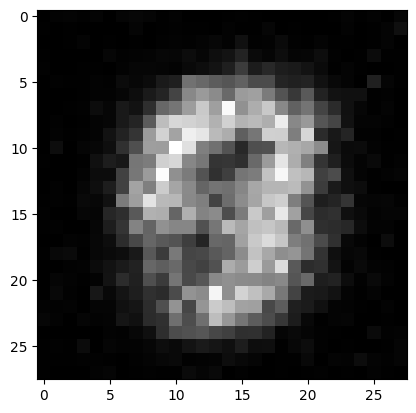

In [32]:

torch.manual_seed(9190)
rand_int = torch.randint(0, 1000, (2,))
image_index = rand_int[0]
image = mnist_testset[image_index][0]
image.shape
plt.imshow(reconstruct_image(image).reshape([28,28]), cmap = "gray")

# Testing and plots:

In [10]:
# Load models
model_conv = torch.load('vae_conv')
model = torch.load('vae_linear')
train_vec_model = torch.load('train_vec_model')
train_vec_model_conv = torch.load('train_vec_model_conv')
test_vec_model = torch.load('test_vec_model')
test_vec_model_conv = torch.load('test_vec_model_conv')

## Plot of loss for the two models:


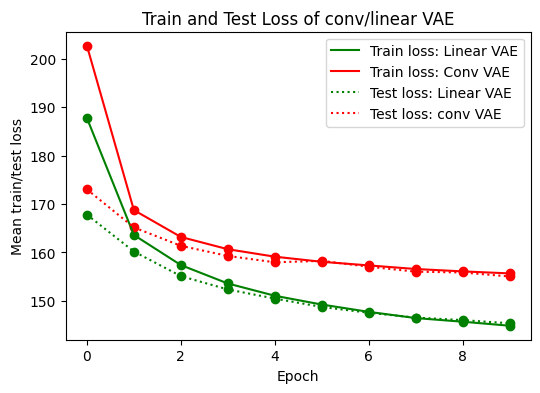

In [10]:

fig = plt.figure(figsize = (6, 4))
# Plot the train loss
plt.plot(train_vec_model, label='Train loss: Linear VAE', color = "green")
plt.plot(train_vec_model_conv, label='Train loss: Conv VAE', color = "red")

# Plot the test loss
plt.plot(test_vec_model, label='Test loss: Linear VAE', linestyle = "dotted", color = "green")
plt.plot(test_vec_model_conv, label='Test loss: conv VAE', linestyle = "dotted", color = "red")

# Plot the train loss
plt.scatter(list(range(0, 10)), train_vec_model, color = "green")
plt.scatter(list(range(0,10)), train_vec_model_conv, color = "red")

# Plot the test loss
plt.scatter(list(range(0,10)), test_vec_model, color = "green")
plt.scatter(list(range(0,10)), test_vec_model_conv, color = "red")

# Add a legend
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean train/test loss")
# Add a title
plt.title("Train and Test Loss of conv/linear VAE")

# Show the plot
plt.show()
# save figure.  
fig.savefig('images/training.png', format = 'png', dpi = 1200)

## Plot of reconstructed images:

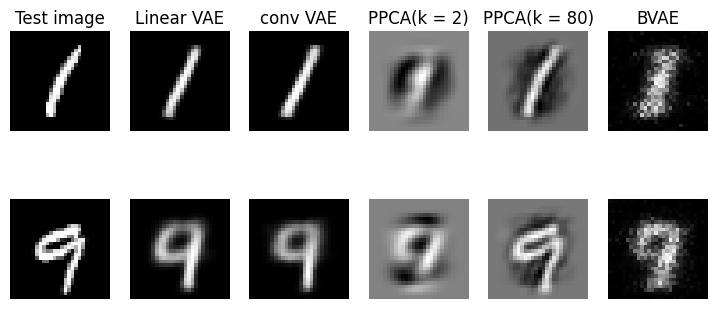

In [75]:
#torch.manual_seed(2024)
#torch.manual_seed(99)
torch.manual_seed(2)
#torch.manual_seed(1234523) #8,1
#torch.manual_seed(11199) # 2, 1
#torch.manual_seed(93)
# Get a batch of data from the test set
#data, _ = next(iter(test_loader))
rand_int = torch.randint(0, 1000, (2,))

#############################################
image_index = rand_int[0]
image = mnist_testset[image_index][0]
# Pass the data through the model VAE
output, _, _ = model(image)
# Get the reconstructed image from the batch
reconstructed_image_model = output.reshape((28,28))
# Pass the data through the model_conv VAE
output, _, _ = model_conv(image.unsqueeze(0))
# Get the reconstructed image from the batch
reconstructed_image_model_conv = output.squeeze(0).squeeze(0)
reconstructed_image_PPCA = xstar[:,image_index].reshape((28,28))
reconstructed_image_PPCA_HD = xstar_high_dim[:,image_index].reshape((28,28))
recon_BVAE = reconstruct_image(image).reshape([28,28])
#############################################
# Second image from test set
image_index = rand_int[1]
image1 = mnist_testset[image_index][0]
# Pass the data through the model VAE
output, _, _ = model(image1)
# Get the reconstructed image from the batch
reconstructed_image_model1 = output.reshape((28,28))
# Pass the data through the model_conv VAE
output, _, _ = model_conv(image1.unsqueeze(0))
# Get the reconstructed image from the batch
reconstructed_image_model_conv1 = output.squeeze(0).squeeze(0)
reconstructed_image_PPCA1 = xstar[:,image_index].reshape((28,28))
reconstructed_image_PPCA_HD1 = xstar_high_dim[:,image_index].reshape((28,28))
recon_BVAE1 = reconstruct_image(image1).reshape([28,28])

## Pass the data through the diffusion model (TODO: skal der stadig være to underscores?)
#output, _, _ = model_diff(data)
## Get the reconstructed image from the batch
#reconstructed_image_model_diff = output[image_index]

# Plot the original image and the reconstructed images side by side
fig, ax = plt.subplots(2, 6, figsize=(9, 4))
ax[0,0].imshow(image.detach().squeeze(0).numpy(), cmap = "gray")
ax[0,0].set_title("Test image")
ax[0,1].imshow(reconstructed_image_model.detach().numpy(), cmap = "gray")
ax[0,1].set_title("Linear VAE")
ax[0,3].imshow(reconstructed_image_PPCA, cmap = "gray")
ax[0,3].set_title("PPCA(k = 2)")
ax[0,4].imshow(reconstructed_image_PPCA_HD, cmap = "gray")
ax[0,4].set_title("PPCA(k = 80)")
ax[0,5].imshow(recon_BVAE, cmap = "gray")
ax[0,5].set_title("BVAE")
ax[0,2].imshow(reconstructed_image_model_conv.detach().numpy(), cmap = "gray")
ax[0,2].set_title("conv VAE")
ax[1,0].imshow(image1.detach().squeeze(0).numpy(), cmap = "gray")
ax[1,1].imshow(reconstructed_image_model1.detach().numpy(), cmap = "gray")
ax[1,2].imshow(reconstructed_image_model_conv1.detach().numpy(), cmap = "gray")
ax[1,3].imshow(reconstructed_image_PPCA1, cmap = "gray")
ax[1,4].imshow(reconstructed_image_PPCA_HD1, cmap = "gray")
ax[1,5].imshow(recon_BVAE1, cmap = "gray")

for i in range(2):
    for j in range(6):
        ax[i,j].axis('off')
plt.show()
#image.shape


fig.savefig('images/recon.png', format = 'png', dpi = 600)

## Mean reconstruction error:

In [67]:
# Initialize lists to store the reconstruction errors
reconstruction_errors_model = []
reconstruction_errors_model_conv = []
reconstruction_errors_model_bvae = []


# Iterate through the test data
count = 0

for data, _ in test_loader:
    if count > 60:
        break
    else:
        count += 1
        # Pass the data through the model VAE
        output, _, _ = model(data)
        # Calculate the reconstruction error
        reconstruction_error = F.mse_loss(torch.reshape(output, (output.shape[0], 1, 28,28)), data)
        ## Add the reconstruction error to the list
        reconstruction_errors_model.append(reconstruction_error.detach().numpy())

        ## Pass the data through the model_conv VAE
        output, _, _ = model_conv(data)
        # Calculate the reconstruction error
        reconstruction_error = F.mse_loss(output, data)
        # Add the reconstruction error to the list
        reconstruction_errors_model_conv.append(reconstruction_error.detach().numpy())

        # BVAE
        output =  reconstruct_batch(data)
        output = output.squeeze(0).squeeze(0).unsqueeze(1).reshape([128, 1, 28, 28])
        # Calculate the reconstruction error
        reconstruction_error = F.mse_loss(output, data)
        # Add the reconstruction error to the list
        reconstruction_errors_model_bvae.append(reconstruction_error.detach().numpy())


# Calculate the mean reconstruction errors
mean_reconstruction_error_model = sum(reconstruction_errors_model) / len(reconstruction_errors_model)
mean_reconstruction_error_model_conv = sum(reconstruction_errors_model_conv) / len(reconstruction_errors_model_conv)
mean_reconstruction_error_model_bvae = sum(reconstruction_errors_model_bvae) / len(reconstruction_errors_model_bvae)

print("Mean reconstruction error:")
print("Linear VAE: {:.4f}".format(mean_reconstruction_error_model))
print("Conv VAE: {:.4f}".format(mean_reconstruction_error_model_conv))
print("Bayes VAE: {:.4f}".format(mean_reconstruction_error_model_bvae))

Mean reconstruction error:
Linear VAE: 0.0389
Conv VAE: 0.0434
Bayes VAE: 0.0596


In [148]:

test_loader1 = torch.utils.data.DataLoader(mnist_testset, batch_size=len(mnist_testset), shuffle=False)
images, labels = next(iter(test_loader1))
images.shape
ims = images.squeeze(1)
ims = ims.reshape(10_000, 784)
means_pca = [torch.mean(torch.tensor([F.mse_loss(im1, im2 / im2.max()) for (im1, im2) in zip(ims, np.transpose(xstar_high_dim))])), 
torch.mean(torch.tensor([F.mse_loss(im1, im2 / im2.max()) for (im1, im2) in zip(ims, np.transpose(xstar))]))]


print("Mean reconstruction error:")
print("PCA(k = 80): {:.4f}".format(means_pca[0]))
print("PCA(k = 2): {:.4f}".format(means_pca[1]))


Mean reconstruction error:
PCA(k = 80): 0.0581
PCA(k = 2): 0.1630


Number of parameters of each model:

In [118]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters of the linear VAE:",  count_parameters(model))
print("Number of parameters of the convolutional VAE:",  count_parameters(model_conv))

Number of parameters of the linear VAE: 709588
Number of parameters of the convolutional VAE: 68581


## Plot of mean latent representation:

In [49]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img_flat)[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

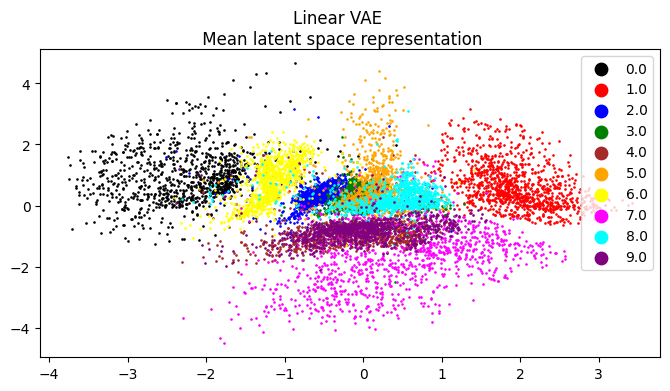

In [50]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots(figsize = (8,4))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
fig.suptitle("Linear VAE \n Mean latent space representation")
plt.show()

In [59]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
results_conv = torch.zeros((128*B,2))
results_bvae = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img)
        mean_img_conv = model_conv.encoder(an_img.unsqueeze(0)).chunk(2, dim = 1)[0]
        mean_img = model.encode(an_img_flat)[0]
        mean_img_bvae = bvae.encoder(an_img)[0]
        results[l] = mean_img
        results_conv[l] = mean_img_conv
        results_bvae[l] = mean_img_bvae
        l +=1
results = results[:l,:]
results_conv = results_conv[:l,:]
results_bvae = results_bvae[:l,:]
all_labels = all_labels[:l]

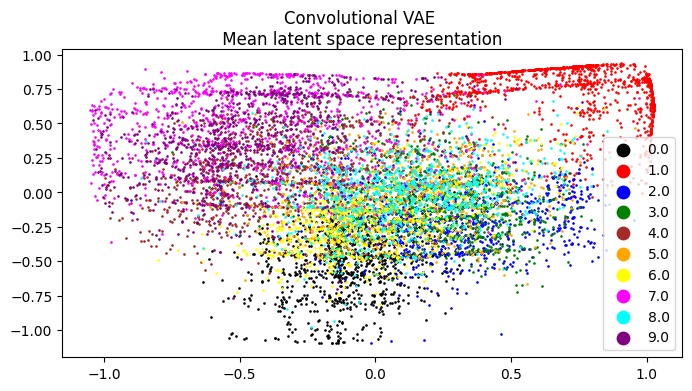

In [60]:


results_for_plot = results_conv.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots(figsize = (8,4))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
fig.suptitle("Convolutional VAE \n Mean latent space representation ")
plt.show()

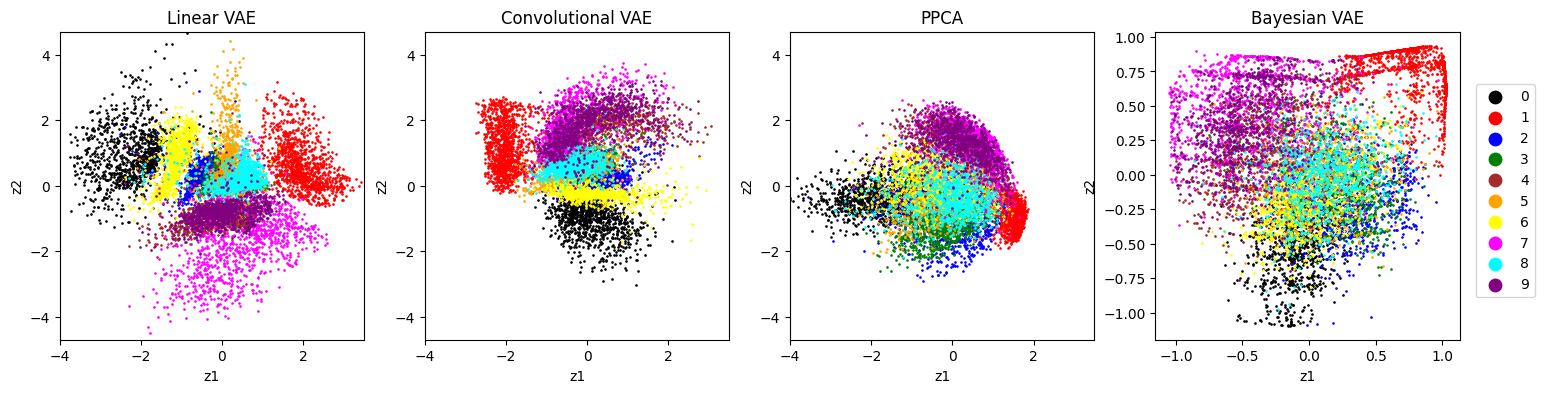

In [86]:
fig, ax = plt.subplots(1, 4, figsize = (16,4))

results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

for g in np.unique(group):
    ix = np.where(group == g)
    ax[0].scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax[0].set_title("Linear VAE")

results_for_plot = results_conv.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
for g in np.unique(group):
    ix = np.where(group == g)
    ax[1].scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)




ax[1].set_title("Convolutional VAE")

# create a single legend
results_for_plot = z_values.detach().numpy().T  # detach from torch and made into numpy
scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = mnist_testset.targets

for g in np.unique(group):
    ix = np.where(group == g)
    ax[2].scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax[2].set_title("PPCA")


## BVAE

results_for_plot = results_bvae.detach().numpy()
scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

for g in np.unique(group):
    ix = np.where(group == g)
    ax[3].scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax[3].set_title("Bayesian VAE")


# Set fixed axis over all subplots. 
ax[0].set_xlim(-4, 3.5)
ax[0].set_ylim(-4.7, 4.7)
ax[1].set_xlim(-4, 3.5)
ax[1].set_ylim(-4.7, 4.7)
ax[2].set_xlim(-4, 3.5)
ax[2].set_ylim(-4.7, 4.7)


ax[0].set_xlabel("z1")
ax[0].set_ylabel("z2")
ax[1].set_xlabel("z1")
ax[1].set_ylabel("z2")
ax[2].set_xlabel("z1")
ax[2].set_ylabel("z2")
ax[3].set_xlabel("z1")
ax[3].set_ylabel("z2")

#ax[3].set_xlim(-1, 1)
#ax[3].set_ylim(-4.7, 4.7)

handles, labels = ax[0].get_legend_handles_labels()
labels = [int(float(x)) for x in labels]


fig.legend(handles, labels, bbox_to_anchor=(1.01, 0.75), loc='upper left', borderaxespad=0., markerscale = 10)
plt.subplots_adjust(right=1)


plt.show()


fig.savefig('images/latent_vae_ppca.png', format = 'png', dpi = 600, bbox_inches='tight')

# Bayes PCA posterior predictive images from Julia

In [ ]:
post_bayes_pca = np.loadtxt(open("post_pred_recon.csv", "rb"), delimiter=",", skiprows=1)

fig = plt.figure()
plt.imshow(np.transpose(post_bayes_pca[:, 2]).reshape(28,28), cmap = "gray")
plt.axis("off")
plt.title("Posterior predictive: MNIST 9")
plt.show()

fig.savefig('images/bayes_ppca.png', format = 'png', dpi = 600, bbox_inches='tight')

# Generation

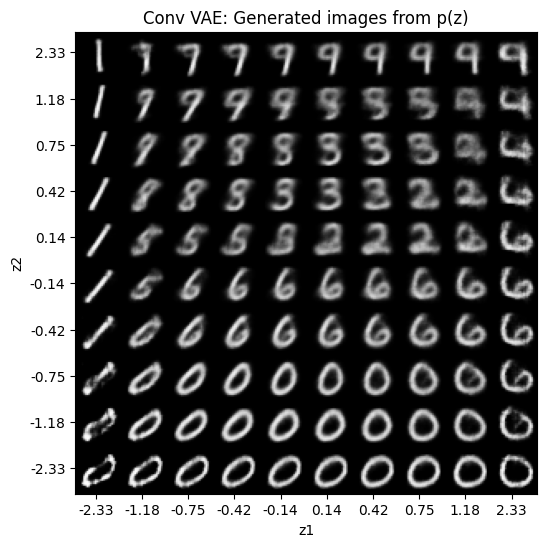

In [82]:
from scipy.stats import norm

# display a 2D manifold of the digits
n = 10  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.99, 0.01, n))

z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid1 = torch.sigmoid(model_conv.decoder(torch.tensor(z_grid, dtype = torch.float)).reshape(n, n, digit_size, digit_size).detach()).numpy()

plt.figure(figsize=(6, 6))
plt.imshow(np.block(list(map(list, x_pred_grid1))), cmap='gray')
plt.xticks(np.arange(12, 12 + 28 * n, step = 28), np.around(z1, decimals = 2))
plt.yticks(np.arange(12, 12 + 28 * n, step = 28), np.around(z2, decimals = 2))
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Conv VAE: Generated images from p(z)")
plt.show()

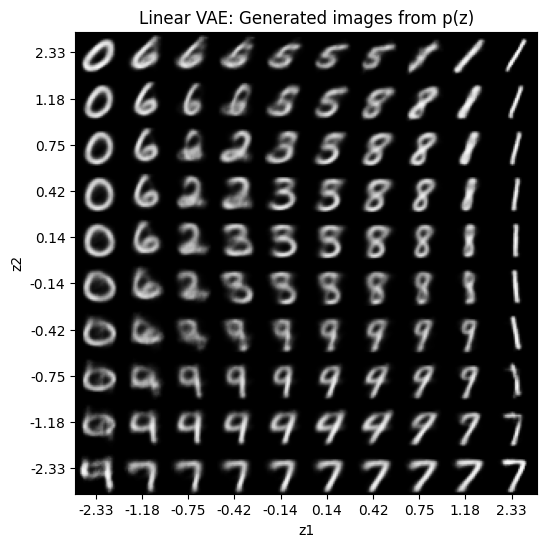

In [83]:

x_pred_grid2 = model.decode(torch.tensor(z_grid, dtype = torch.float)).reshape(n, n, digit_size, digit_size).detach().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(np.block(list(map(list, x_pred_grid2))), cmap='gray')
plt.xticks(np.arange(12, 12 + 28 * n, step = 28), np.around(z1, decimals = 2))
plt.yticks(np.arange(12, 12 + 28 * n, step = 28), np.around(z2, decimals = 2))
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Linear VAE: Generated images from p(z)")
plt.show()

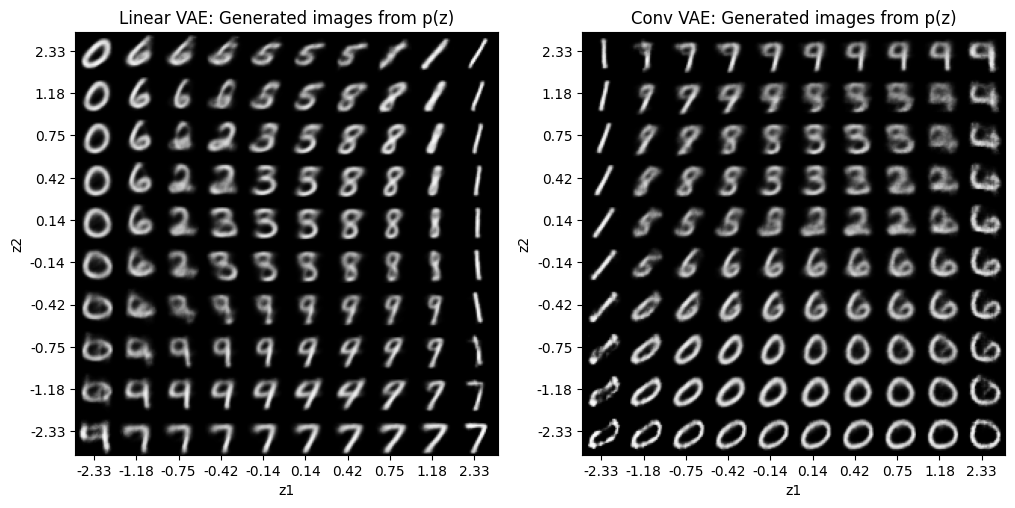

In [84]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[1].imshow(np.block(list(map(list, x_pred_grid1))), cmap='gray')
axs[1].set_xticks(np.arange(12, 12 + 28 * n, step = 28), np.around(z1, decimals = 2))
axs[1].set_yticks(np.arange(12, 12 + 28 * n, step = 28), np.around(z2, decimals = 2))
axs[1].set_xlabel("z1")
axs[1].set_ylabel("z2")
axs[1].set_title("Conv VAE: Generated images from p(z)")

axs[0].imshow(np.block(list(map(list, x_pred_grid2))), cmap='gray')
axs[0].set_xticks(np.arange(12, 12 + 28 * n, step = 28), np.around(z1, decimals = 2))
axs[0].set_yticks(np.arange(12, 12 + 28 * n, step = 28), np.around(z2, decimals = 2))
#axs[1].set_yticks([])
axs[0].set_xlabel("z1")
axs[0].set_ylabel("z2")
axs[0].set_title("Linear VAE: Generated images from p(z)")

plt.show()
fig.savefig('images/generated_images.png', format = 'png', dpi = 600, bbox_inches='tight')
